In [1]:
import pickle
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

In [2]:
# load the helper functions
from analysis_utils.describe_target import decomp_SST

from analysis_utils.flagged_uids import flagged_uids


# load the lsms data

In [3]:
root_data_dir = "../../Data"
lsms_pth = f"{root_data_dir}/lsms/processed/labels_cluster_v1.csv"
lsms_df = pd.read_csv(lsms_pth)

# remove flagged ids form dataset
lsms_df = lsms_df[~lsms_df.unique_id.isin(flagged_uids)].reset_index(drop = True)

# Household robustness figure

In [4]:
# load results from the household analysis
# load the data
# save the results
pth = "../analysis/results/robustness/robust_households.pkl"
with open(pth, 'rb') as f:
    results = pickle.load(f)

# aggregate results and add standard errors.
agg_mean_results = {k: np.mean(v, axis = 1) for k,v in results.items()}
agg_95ci_results = {k: 1.96*np.std(v, axis = 1)/np.sqrt(10) for k,v in results.items()}
agg_results = {
    'mean': agg_mean_results,
    'ci': agg_95ci_results
}   

In [5]:
# Within variance in relation to the number of households per cluster
thresholds = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
n = []
n_clusters = []
n_clusters_cntry = []
variance_share = []
within_variance = []
between_variance = []
for i in thresholds:
    sub_df = lsms_df[lsms_df.n_households >= i].reset_index(drop = True)
    SSW, SSB, SST = decomp_SST(sub_df, 'cluster_id', 'log_mean_pc_cons_usd_2017', verbose = False)
    variance_share.append(SSW/SST)
    sub_n = len(sub_df)
    sub_c = len(np.unique(sub_df.cluster_id))
    within_variance.append(SSW / (sub_n - sub_c))
    between_variance.append(SSB / (sub_c - 1))
    n.append(sub_n)
    n_clusters.append(sub_c)
    n_country = sub_df.groupby('country')['cluster_id'].nunique()
    n_clusters_cntry.append(n_country)

# number of households per cluster
n_clusters_cntry_df = pd.DataFrame(n_clusters_cntry).reset_index(drop = True)
n_clusters_cntry_df['n_households'] = thresholds
n_clusters_cntry_df = n_clusters_cntry_df.fillna(0)

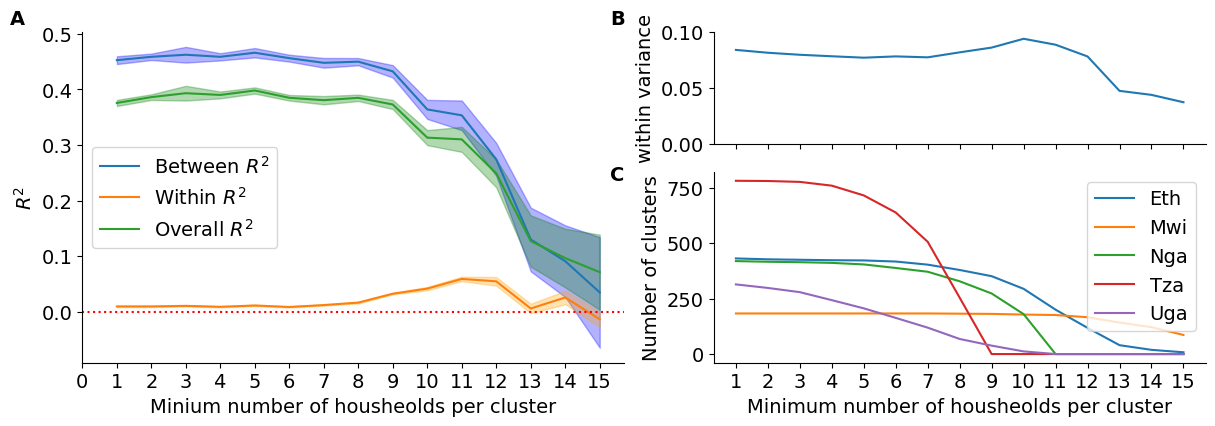

In [6]:
# set the font size for matplotlib and the font family.
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

fig = plt.figure(layout="constrained", figsize = (12,4))

gs = GridSpec(2, 2, figure=fig, width_ratios=[1.1,1], height_ratios = [1,1.7])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,1], sharex=ax2)
plt.setp(ax2.get_xticklabels(), visible=False)

# plot the results
ax1.plot(list(range(1,16)), agg_results['mean']['between_r2'], label = 'Between $R^2$')
ax1.plot(list(range(1,16)), agg_results['mean']['within_r2'], label = 'Within $R^2$')
ax1.plot(list(range(1,16)), agg_results['mean']['combined_r2'], label = 'Overall $R^2$')

# plot confidence intervals
# add confidence bands
ax1.fill_between(list(range(1, 16)), agg_results['mean']['between_r2'] - agg_results['ci']['between_r2'], agg_results['mean']['between_r2'] + agg_results['ci']['between_r2'], alpha=0.3, color='blue')
ax1.fill_between(list(range(1, 16)), agg_results['mean']['within_r2'] - agg_results['ci']['within_r2'], agg_results['mean']['within_r2'] + agg_results['ci']['within_r2'], alpha=0.3, color='orange')
ax1.fill_between(list(range(1, 16)), agg_results['mean']['combined_r2'] - agg_results['ci']['combined_r2'], agg_results['mean']['combined_r2'] + agg_results['ci']['combined_r2'], alpha=0.3, color='green')

# change the legend and ticks
ax1.legend(loc = 'center left')
ax1.set_xlabel("Minium number of housheolds per cluster")
ax1.set_ylabel("$R^2$")
ax1.axhline(y=0, color='red', linestyle='dotted', label='y = 0')  # Add red dotted line at y = 0
ax1.set_xticks(range(0, 16))  # Set x-axis ticks from 1 to 10

# plot the share of variance
# ax2.plot(thresholds, variance_share)
# ax2.set_ylabel('WSS / TSS')

ax2.plot(thresholds, within_variance)
ax2.set_yticks([0,0.05,0.1])

ax2.set_ylabel('within variance')

# ax2.plot(thresholds, between_variance)
# ax2.set_ylabel('between variance')

# plot the number of households
ax3.plot(n_clusters_cntry_df['n_households'], n_clusters_cntry_df['eth'],label = 'Eth')
ax3.plot(n_clusters_cntry_df['n_households'], n_clusters_cntry_df['mwi'],label = 'Mwi')
ax3.plot(n_clusters_cntry_df['n_households'], n_clusters_cntry_df['nga'],label = 'Nga')
ax3.plot(n_clusters_cntry_df['n_households'], n_clusters_cntry_df['tza'],label = 'Tza')
ax3.plot(n_clusters_cntry_df['n_households'], n_clusters_cntry_df['uga'],label = 'Uga')
ax3.legend(ncols = 1)
ax3.set_xticks(ticks = thresholds)
ax3.set_xlabel("Minimum number of housheolds per cluster")
ax3.set_ylabel('Number of clusters')

ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax3.spines[['right', 'top']].set_visible(False)

fig.text(0,.99,'A',weight = 'bold', size = 14)
fig.text(0.5,.99,'B',weight = 'bold', size = 14)
fig.text(0.5,.6,'C',weight = 'bold', size = 14)

plt.savefig("../figures/results/R2_vs_households.png", dpi = 300, bbox_inches = 'tight' )
plt.show()

In [7]:
print('Number of observations')
print(n)
print('\nNumber of clusters')
print(n_clusters)
print("\nwithin R2 shares")
print(np.round(agg_results['mean']['within_r2'],4))

Number of observations
[6401, 6289, 6149, 5872, 5540, 5026, 4354, 3270, 2284, 1732, 881, 626, 364, 280, 188]

Number of clusters
[2128, 2104, 2077, 2019, 1930, 1789, 1582, 1211, 843, 664, 376, 284, 182, 140, 94]

within R2 shares
[ 0.0094  0.0094  0.0105  0.0088  0.0111  0.0084  0.0119  0.0163  0.0323
  0.0415  0.0589  0.0546  0.0057  0.0256 -0.0137]


# Temporal predictions for different subsamples

In [9]:
pth = '../analysis/results/robustness/rurb.pkl'
with open(pth, 'rb') as f:
    rurb_results = pickle.load(f)

# take average over all predictions
pred_vars = ['y_hat_' + str(i) for i in range(10)]
rurb_results['predictions']['rural']['mean_y_hat'] = rurb_results['predictions']['rural'][pred_vars].mean(axis = 1)
rurb_results['predictions']['urban']['mean_y_hat'] = rurb_results['predictions']['urban'][pred_vars].mean(axis = 1)

r2_urban = {
    'mean': np.mean(rurb_results['within_r2']['urban']),
    'se': np.std(rurb_results['within_r2']['urban'])/np.sqrt(10)
}

r2_rural = {
    'mean': np.mean(rurb_results['within_r2']['rural']),
    'se': np.std(rurb_results['within_r2']['rural'])/np.sqrt(10)
}

In [10]:
pth = '../analysis/results/robustness/pre_post.pkl'
with open(pth, 'rb') as f:
    pre_post_results = pickle.load(f)

pred_vars = ['y_hat_' + str(i) for i in range(10)]
pre_post_results['predictions']['pre']['mean_y_hat'] = pre_post_results['predictions']['pre'][pred_vars].mean(axis = 1)
pre_post_results['predictions']['post']['mean_y_hat'] = pre_post_results['predictions']['post'][pred_vars].mean(axis = 1)

r2_pre = {
    'mean': np.mean(pre_post_results['within_r2']['pre']),
    'se': np.std(pre_post_results['within_r2']['pre'])/np.sqrt(10)
}

r2_post = {
    'mean': np.mean(pre_post_results['within_r2']['post']),
    'se': np.std(pre_post_results['within_r2']['post'])/np.sqrt(10)
}


In [11]:
# load the min years results
pth = '../analysis/results/robustness/min_years.pkl'
with open(pth, 'rb') as f:
    min_years_results = pickle.load(f)
    
pred_vars = ['y_hat_' + str(i) for i in range(10)]
min_years_results['predictions']['min_1_years']['mean_y_hat'] = min_years_results['predictions']['min_1_years'][pred_vars].mean(axis = 1)
min_years_results['predictions']['min_2_years']['mean_y_hat'] = min_years_results['predictions']['min_2_years'][pred_vars].mean(axis = 1)

r2_min_1 = {
    'mean': np.mean(min_years_results['within_r2']['min_1_years']),
    'se': np.std(min_years_results['within_r2']['min_1_years'])/np.sqrt(10)
}

r2_min_2 = {
    'mean': np.mean(min_years_results['within_r2']['min_2_years']),
    'se': np.std(min_years_results['within_r2']['min_2_years'])/np.sqrt(10)
}

In [12]:
plot_vals = [
    (pre_post_results['predictions']['pre']['y'], pre_post_results['predictions']['pre']['mean_y_hat']),
    (rurb_results['predictions']['rural']['y'], rurb_results['predictions']['rural']['mean_y_hat']),
    (min_years_results['predictions']['min_1_years']['y'], min_years_results['predictions']['min_1_years']['mean_y_hat']),
    (pre_post_results['predictions']['post']['y'], pre_post_results['predictions']['post']['mean_y_hat']),
    (rurb_results['predictions']['urban']['y'], rurb_results['predictions']['urban']['mean_y_hat']),
    (min_years_results['predictions']['min_2_years']['y'], min_years_results['predictions']['min_2_years']['mean_y_hat'])
]

r2_vals = [
    r2_pre,
    r2_rural,
    r2_min_1,
    r2_post, 
    r2_urban, 
    r2_min_2
]

N_vals = [
    pre_post_results['n']['pre'],
    rurb_results['n']['rural'],
    min_years_results['n']['min_1_years'],
    pre_post_results['n']['post'],
    rurb_results['n']['urban'],
    min_years_results['n']['min_2_years']
]

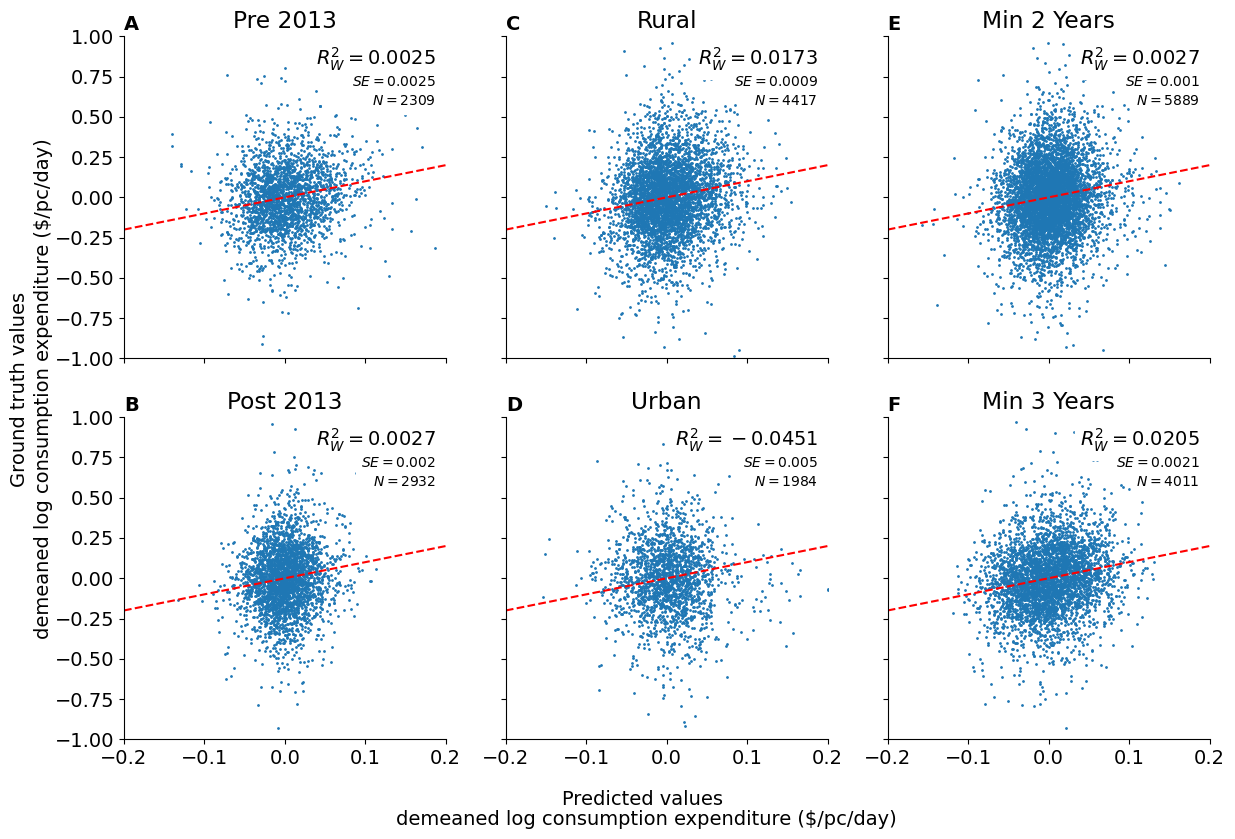

In [13]:
# set the font size for matplotlib and the font family.
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

# make the actual plot
fig, axes = plt.subplots(2,3, figsize=(12, 8), sharex = True, sharey = True)
titles = ['Pre 2013','Rural', 'Min 2 Years', 'Post 2013','Urban', 'Min 3 Years']
letters = ['A','C','E','B','D','F']
for idx, ax in enumerate(axes.flatten()):
    vals = plot_vals[idx]
    y = vals[0]
    y_hat = vals[1]
    r2 = r2_vals[idx]
    ax.scatter(y_hat, y, s = 1)
    #ax.plot([min(y_hat), max(y_hat)], [min(y_hat), max(y_hat)], color='red', linestyle='--')  # Line of perfect correlation
    ax.plot([-.2, .2], [-.2, .2], color='red', linestyle='--')  # Line of perfect correlation

    ax.set_ylim(ymin = -1, ymax = 1)
    ax.set_xlim(xmin = -.2, xmax = .2)

    ax.set_title(titles[idx])
    ax.spines[['right', 'top']].set_visible(False)
    
    
    # Add text in the top right corner
    text_x = 0.97  # Adjust this value for horizontal positioning
    text_y = 0.97  # Adjust this value for vertical positioning
    txt = f"$R^2_W = {np.round(r2['mean'], 4)}$"
    ax.text(text_x, text_y, txt, transform=ax.transAxes,
            va='top', ha='right', backgroundcolor='white')

    text_y = 0.88
    se_txt = f"$SE = {np.round(r2['se'], 4)}$"
    ax.text(text_x, text_y, se_txt, transform=ax.transAxes,
            fontsize=10, va='top', ha='right', backgroundcolor='white')
 
    text_y = 0.82
    n_txt = f"$N = {N_vals[idx]}$"
    ax.text(text_x, text_y, n_txt, transform=ax.transAxes,
            fontsize=10, va='top', ha='right', backgroundcolor='white')
    
    text_y = 1.02
    text_x = 0
    ax.text(text_x, text_y, letters[idx], transform=ax.transAxes, weight='bold')



plt.tight_layout()

fig.text(0.5, -.02, "Predicted values ", ha="center")
fig.text(0.5, -.045, "demeaned log consumption expenditure (\$/pc/day)", ha="center")

fig.text(-.03, 0.5, "Ground truth values", va="center", rotation="vertical")
fig.text(-.01, 0.5, "demeaned log consumption expenditure (\$/pc/day)", va="center", rotation="vertical")

# Add spacing between subplots

plt.savefig('../figures/results/robustness_predictions.png', dpi = 300, bbox_inches = 'tight')
# Show the plot
plt.show()


# Cross-country prediction

In [14]:
# load the data
pth = '../analysis/results/robustness/same_cntry_res.pkl'
with open(pth, 'rb') as f:
    same_cntry_res = pickle.load(f)
    
pth = '../analysis/results/robustness/cross_cntry_res.pkl'
with open(pth, 'rb') as f:
    cross_cntry_res = pickle.load(f)
    
same_cntry_df = pd.DataFrame(same_cntry_res)

# combine cross cntry and same cntry results to one matrix
res_dict = {}
for cntry, res in cross_cntry_res.items():
    res_df = pd.DataFrame(res)
    same_df = same_cntry_df[same_cntry_df.country == cntry]
    same_df = same_df.rename(columns = {'country': 'val_cntry'})
    res_df = pd.concat([res_df, same_df], ignore_index = True)
    res_dict[cntry] = res_df.sort_values(by = 'val_cntry').reset_index(drop = True)
    
res_dict['eth']
between_df = pd.DataFrame({
    'eth': [], 
    'mwi': [],
    'nga': [],
    'tza': [],
    'uga': []
})

within_df = copy.deepcopy(between_df)
overall_df = copy.deepcopy(between_df)

final_res = {
    'between_r2': between_df,
    'within_r2': within_df,
    'overall_r2': overall_df
}

for cntry, res_df in res_dict.items():
    for r2, final_df in final_res.items():
        aux_df = res_dict[cntry][[r2, 'val_cntry']].T
        aux_df.columns = aux_df[aux_df.index == 'val_cntry'].values[0]
        aux_df = aux_df[aux_df.index != 'val_cntry']
        aux_df = aux_df.rename(index = {r2: cntry})
        final_res[r2] = pd.concat([final_df, aux_df], ignore_index = False)
        
for r2, df in final_res.items():
    final_res[r2].columns = [i.upper() for i in final_res[r2].columns.values]
    final_res[r2].index = [i.upper() for i in final_res[r2].index.values]
    final_res[r2] = final_res[r2].sort_index()

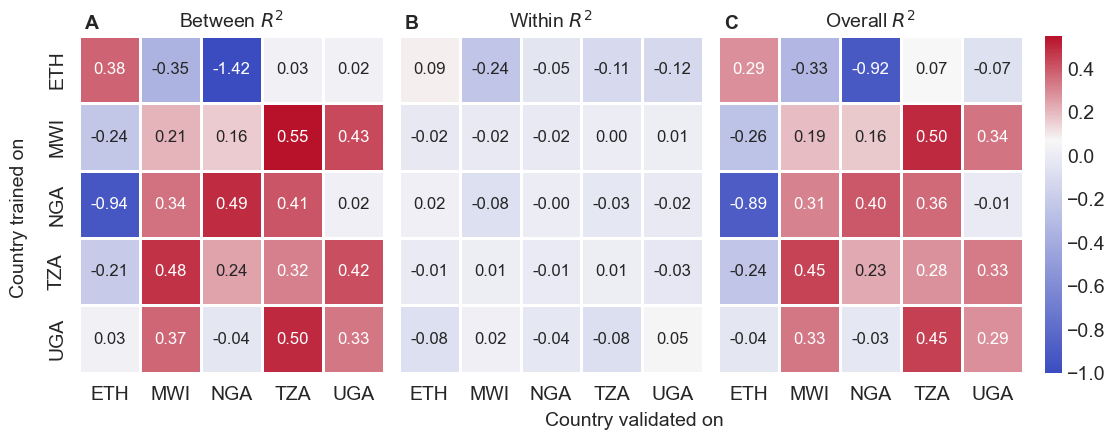

In [15]:
fontsize = 14
letters =  ['A', 'B', 'C']
sns.set_theme(style="white")

# Create a figure and axis for the plot
fig, axes = plt.subplots(1,3, figsize=(12, 4), sharey = True)

data_between = final_res['between_r2'].astype(float)
data_within = final_res['within_r2'].astype(float)
data_overall = final_res['overall_r2'].astype(float)

colors = ['#3B4CC0', '#F7F7F7', '#B8122A']  # Blue, Gray, Red

# Define the positions for the color transitions
positions = [0, 0.69, 1]  # Corresponding to blue, gray, and red

# Create a colormap with color transitions around 0
cmap = LinearSegmentedColormap.from_list("BlueGrayRed", list(zip(positions, colors)), N=256)

# Define the color map with segmented colors

common_vmin = max(min(data_between.min().min(), data_within.min().min(), data_overall.min().min()),-1)
common_vmax = max(data_between.max().max(), data_within.max().max(), data_overall.max().min())

#cmap = LinearSegmentedColormap.from_list("BlueGrayRed", colors, N=256)


#sns.heatmap(data, cmap='coolwarm', annot=True, fmt='.2f', cbar=True, ax=ax, linewidths=1)

# Create heatmaps for each data frame and place them in the subplots
heatmap_between = sns.heatmap(data_between, cmap=cmap, annot=True, fmt='.2f', cbar=False, ax=axes[0], linewidths=1, vmin=common_vmin, vmax=common_vmax)
heatmap_within = sns.heatmap(data_within, cmap=cmap, annot=True, fmt='.2f', cbar=False, ax=axes[1], linewidths=1, vmin=common_vmin, vmax=common_vmax)
heatmap_overall = sns.heatmap(data_overall, cmap=cmap, annot=True, fmt='.2f', cbar=False, ax=axes[2], linewidths=1, vmin=common_vmin, vmax=common_vmax)

plt.tight_layout()

# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
# cbar = fig.colorbar(heatmap_overall, cax=cbar_ax)
# Create a common color bar based on vmin and vmax
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=common_vmin, vmax=common_vmax))
sm.set_array([])  # Dummy empty array for the ScalarMappable

# Add the color bar to the figure
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), pad=0.02)
cbar.ax.tick_params(size=0, labelsize = fontsize)
cbar.outline.set_visible(False)

# Set titles for each subplot
heatmap_between.set_title('Between $R^2$', size = fontsize)
heatmap_within.set_title('Within $R^2$', size = fontsize)
heatmap_overall.set_title('Overall $R^2$', size = fontsize)

for ax in axes:
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)

# add letter to every plot
text_y = 1.02
text_x = 0.02
axes[0].text(text_x, text_y, 'A', transform=axes[0].transAxes, weight='bold', size = fontsize)
axes[1].text(text_x, text_y, 'B', transform=axes[1].transAxes, weight='bold', size = fontsize)
axes[2].text(text_x, text_y, 'C', transform=axes[2].transAxes, weight='bold', size = fontsize)

# Show the plot
fig.text(0.5, -.02, "Country validated on", ha="center", size = fontsize)
fig.text(-.02, 0.5, "Country trained on", va="center", rotation="vertical", size = fontsize)
plt.savefig('../figures/results/cross_cntry_validation.png', dpi = 300, bbox_inches='tight')
plt.show()